# Селекция и обучение предиктивных моделей

**Цели и задачи:**<br>
1. Создать датасеты для обучения и тестирования моделей:<br>
- создать и протестировать датасеты с разным набором переменных (большой - "phase" и сокращенный - "total").<br>
2. Провести селекцию моделей с целью выбора наиболее эффективной.<br>
3. Обучить и протестировать модель для прогнозирования урожайности:<br>
- обучение модели на общих данных (по всем регионам) и на данных по отдельным регионам.<br>

## Загрузка необходимых библиотек

In [1]:
## Загрузка необходимых библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from catboost import CatBoostRegressor, Pool, cv
import xgboost as xgb

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler

C:\Users\uovorop\Anaconda3\lib\site-packages\xgboost\compat.py:31: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


## 1. Подготовка датасета для обучения и тестирования

### 1.1 Датасет типа "total"

**Комментарий:**<br>
С цель сокращения использования вычислительных ресурсов, оптимизации при построении моделей и улучшения их интерретации, предлагается использовать датасет с сокращенным количеством переменных (датасет типа "total" - 45 переменных). С этой целью предлагается обучать модели только на переменных имеющих агрегацию значений по всему сезону (см. набор данных "_total_data_" из ноутбука "_**preparation_mldata_4phase.ipynb**_").

In [2]:
## Чтение данных из файла
weather = pd.read_csv('DATA/weather_data_total4.csv.gz', compression='gzip', header=0, sep=';'
                      , quotechar='"')
municip = pd.read_csv('INPUT/id_муниципалитета.csv.zip', compression='zip', header=0, sep=';'
                      , dtype={'digit_id': 'object'}, quotechar='"')
settl = pd.read_csv('DATA/Settlement_Id.zip', compression='zip', header=0, sep=';'
                    , dtype={'digit_id': 'object'}, quotechar='"')
target = pd.read_csv('INPUT/target.csv.zip', compression='zip', header=0, sep=';', decimal=','
                     , dtype={'digit_id': 'object'}, quotechar='"')
diff_trend = pd.read_csv('DATA/data_ssa.csv.gz', compression='gzip', header=0, sep=';'
                         , dtype={'yield_code': 'object'}, quotechar='"')

In [3]:
## Добавление id метеостанций к фрейму с целевой переменной
# добавление данных по урожайности и накопленного тренда урожайности
target = target.loc[~target['check'].isin([0])]
target['triplet'] = target['digit_id'].astype(str).str[:3]
target['solo'] = target['digit_id'].astype(str).str[0]+'00'
diff_trend = diff_trend.loc[pd.notnull(diff_trend['diff_cumulative']), ['year', 'yield_code', 'diff_cumulative']]
# создание массива по урожайности
target = pd.merge(target, diff_trend, how='left', left_on=['year', 'triplet'], right_on=['year', 'yield_code'])
target = pd.merge(target, diff_trend, how='left', left_on=['year', 'solo'], right_on=['year', 'yield_code'])

# очистка урожайности от тренда
target['trendless'] = np.nan
target.loc[pd.isnull(target['trendless']), 'trendless'] = target.loc[pd.isnull(target['trendless']), 'yield'] - target.loc[pd.isnull(target['trendless']), 'diff_cumulative_x']
target.loc[pd.isnull(target['trendless']), 'trendless'] = target.loc[pd.isnull(target['trendless']), 'yield'] - target.loc[pd.isnull(target['trendless']), 'diff_cumulative_y']
target.dropna(subset=['trendless'], inplace=True)
target = target[['digit_id', 'year', 'federal_distr', 'region', 'category', 'trendless']]

# добавление данных по метеостанциям
meteo = settl[['digit_id', 'meteoid']].drop_duplicates()
target = pd.merge(target, meteo, how='left', on=['digit_id'])

# добавление данных с идентификаторами муниципалитетов
target = pd.merge(target, municip[['digit_id', 'id_municip']], how='left', on=['digit_id'])
target.drop_duplicates(keep='first', inplace=True, ignore_index=True) # удаление дубликатов

In [4]:
## Средние значения показателей для заполнения значений Nan
geolocation = settl.groupby(['digit_id']).agg(
    north_border = pd.NamedAgg(column = 'latitude', aggfunc = 'max'),
    south_border = pd.NamedAgg(column = 'latitude', aggfunc = 'min'),
    east_border = pd.NamedAgg(column = 'longitude', aggfunc = 'max'),
    west_border = pd.NamedAgg(column = 'longitude', aggfunc = 'min'),
    central_lat = pd.NamedAgg(column = 'latitude', aggfunc = 'mean'),
    central_lon = pd.NamedAgg(column = 'longitude', aggfunc = 'mean'),
    settl_count = pd.NamedAgg(column = 'settlement', aggfunc = 'count')
)
geolocation.reset_index(inplace=True) # перевод индексов группировки в столбцы
target = pd.merge(target, geolocation, how='left', on=['digit_id'])

In [5]:
## Создание учебного датафрейма
target['rotation'] = target['year']%4 # добавление фичи по севообороту
target.drop(columns=['digit_id'], inplace=True)
data = pd.merge(weather, target, how='right', on=['year', 'meteoid'])
data.drop_duplicates(keep='first', inplace=True, ignore_index=True)
data.dropna(axis=0, how='any', inplace=True)
#data['region_id'] = data['region_id'].astype(int)
data.rename(columns={"trendless": "target"}, inplace=True)

In [6]:
## Список неинформативных столбцов
antitop = [
    'min_baric_tendency',
    'min_u_humidity',
    'max_baric_tendency',
    'max_wind_speed',
    'max_wind_gust_between',
    'diff_cloudiness',
    'max_height_clouds',
    'diff_height_clouds',
    'min_cloudiness',
    'min_height_clouds',
    'min_wind_speed'
]

In [7]:
## Удаление неинформативных столбцов из датафрейма total (для датафрейма "weather_data_total4.csv.gz")
# создание списка неинформативных столбцов
drop_col_tot = []

for items in antitop:
    c = 'total_{}'.format(items)
    drop_col_tot.append(c)

data.drop(columns=drop_col_tot, inplace=True)

In [8]:
data = data.loc[(data['category'] !='КФХ')]
## Преобразование категориальных переменных признака "category" в числовые значения
le = LabelEncoder() # метод преобразования категориальных признаков
# преобразование в числовые значения
data['category'] = le.fit_transform(data['category'])
data['federal_distr'] = le.fit_transform(data['federal_distr'])
data['region'] = le.fit_transform(data['region'])

In [9]:
## Удаление лишних данных
del settl
del meteo
del weather
del municip

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31248 entries, 13361 to 48067
Data columns (total 45 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   year                          31248 non-null  float64
 1   meteoid                       31248 non-null  int64  
 2   total_min_air_temp            31248 non-null  float64
 3   total_min_ground_temp         31248 non-null  float64
 4   total_min_po_press            31248 non-null  float64
 5   total_max_air_temp            31248 non-null  float64
 6   total_max_po_press            31248 non-null  float64
 7   total_max_u_humidity          31248 non-null  float64
 8   total_max_cloudiness          31248 non-null  float64
 9   total_avg_air_temp            31248 non-null  float64
 10  total_avg_po_press            31248 non-null  float64
 11  total_avg_baric_tendency      31248 non-null  float64
 12  total_wind_rumb_radians       31248 non-null  float64
 1

In [11]:
## Формирование датасета и вектора целевой переменной
train_data = data.copy()
train_label = data['target']

# удаление лишних столбцов
train_data = train_data.drop(columns=['year', 'meteoid', 'target'])

In [12]:
# разделение выборки на обучающую и тестовую (80/20) 
X_train, X_test, y_train, y_test = train_test_split(train_data, train_label, test_size=0.25, random_state=42) 

In [14]:
# Тренировочный и тестовый датасет для модели CatBoost (для типа "total")
category = ['category', 'federal_distr', 'region', 'rotation']

train_data = Pool(data=X_train,
                  label= y_train,
                  cat_features=category)

test_data = Pool(data=X_test,
                 cat_features=category)

eval_data = Pool(data=X_test,
                 label=y_test,
                 cat_features=category)

### 1.2 Датасет типа "phase"

**Комментарий:**<br>
Датасет с полным набором переменных (датасет типа "phase" - 165 переменных). Модель обучается на переменных имеющих агрегацию значений по фазам (4 фазы) и по всему сезону (см. набор данных "_weather_" из ноутбука "_**preparation_mldata_4phase.ipynb**_").

In [15]:
## Чтение данных из файла
weather_ph = pd.read_csv('DATA/weather_data_phase4.csv.gz', compression='gzip', header=0, sep=';'
                      , quotechar='"')
municip_ph = pd.read_csv('INPUT/id_муниципалитета.csv.zip', compression='zip', header=0, sep=';'
                      , dtype={'digit_id': 'object'}, quotechar='"')
settl_ph = pd.read_csv('DATA/Settlement_Id.zip', compression='zip', header=0, sep=';'
                    , dtype={'digit_id': 'object'}, quotechar='"')
target_ph = pd.read_csv('INPUT/target.csv.zip', compression='zip', header=0, sep=';', decimal=','
                     , dtype={'digit_id': 'object'}, quotechar='"')
diff_trend_ph = pd.read_csv('DATA/data_ssa.csv.gz', compression='gzip', header=0, sep=';'
                         , dtype={'yield_code': 'object'}, quotechar='"')

In [16]:
## Добавление id метеостанций к фрейму с целевой переменной
# добавление данных по урожайности и накопленного тренда урожайности
target_ph = target_ph.loc[~target_ph['check'].isin([0])]
target_ph['triplet'] = target_ph['digit_id'].astype(str).str[:3]
target_ph['solo'] = target_ph['digit_id'].astype(str).str[0]+'00'
diff_trend_ph = diff_trend_ph.loc[pd.notnull(diff_trend_ph['diff_cumulative']), ['year', 'yield_code', 'diff_cumulative']]
# создание массива по урожайности
target_ph = pd.merge(target_ph, diff_trend_ph, how='left', left_on=['year', 'triplet'], right_on=['year', 'yield_code'])
target_ph = pd.merge(target_ph, diff_trend_ph, how='left', left_on=['year', 'solo'], right_on=['year', 'yield_code'])

# очистка урожайности от тренда
target_ph['trendless'] = np.nan
target_ph.loc[pd.isnull(target_ph['trendless']), 'trendless'] = target_ph.loc[pd.isnull(target_ph['trendless']), 'yield'] - target_ph.loc[pd.isnull(target_ph['trendless']), 'diff_cumulative_x']
target_ph.loc[pd.isnull(target_ph['trendless']), 'trendless'] = target_ph.loc[pd.isnull(target_ph['trendless']), 'yield'] - target_ph.loc[pd.isnull(target_ph['trendless']), 'diff_cumulative_y']
target_ph.dropna(subset=['trendless'], inplace=True)
target_ph = target_ph[['digit_id', 'year', 'federal_distr', 'region', 'category', 'trendless']]

# добавление данных по метеостанциям
meteo_ph = settl_ph[['digit_id', 'meteoid']].drop_duplicates()
target_ph = pd.merge(target_ph, meteo_ph, how='left', on=['digit_id'])

# добавление данных с идентификаторами муниципалитетов
target_ph = pd.merge(target_ph, municip_ph[['digit_id', 'id_municip']], how='left', on=['digit_id'])
target_ph.drop_duplicates(keep='first', inplace=True, ignore_index=True) # удаление дубликатов

In [17]:
## Средние значения показателей для заполнения значений Nan
geolocation_ph = settl_ph.groupby(['digit_id']).agg(
    north_border = pd.NamedAgg(column = 'latitude', aggfunc = 'max'),
    south_border = pd.NamedAgg(column = 'latitude', aggfunc = 'min'),
    east_border = pd.NamedAgg(column = 'longitude', aggfunc = 'max'),
    west_border = pd.NamedAgg(column = 'longitude', aggfunc = 'min'),
    central_lat = pd.NamedAgg(column = 'latitude', aggfunc = 'mean'),
    central_lon = pd.NamedAgg(column = 'longitude', aggfunc = 'mean'),
    settl_count = pd.NamedAgg(column = 'settlement', aggfunc = 'count')
)
geolocation_ph.reset_index(inplace=True) # перевод индексов группировки в столбцы
target_ph = pd.merge(target_ph, geolocation_ph, how='left', on=['digit_id'])

In [18]:
## Создание учебного датафрейма
target_ph['rotation'] = target_ph['year']%4 # добавление фичи по севообороту
target_ph.drop(columns=['digit_id'], inplace=True)
data_ph = pd.merge(weather_ph, target_ph, how='right', on=['year', 'meteoid'])
data_ph.drop_duplicates(keep='first', inplace=True, ignore_index=True)
data_ph.dropna(axis=0, how='any', inplace=True)
data_ph.rename(columns={"trendless": "target"}, inplace=True)

In [19]:
## Список неинформативных столбцов
antitop_ph = [
    'min_baric_tendency',
    'min_u_humidity',
    'max_baric_tendency',
    'max_wind_speed',
    'max_wind_gust_between',
    'diff_cloudiness',
    'max_height_clouds',
    'diff_height_clouds',
    'min_cloudiness',
    'min_height_clouds',
    'min_wind_speed'
]

In [20]:
## Удаление неинформативных столбцов из датафрейма total (для датафрейма "weather_data_total4.csv.gz")
# создание списка неинформативных столбцов
drop_col_tot = []

for items in antitop_ph:
    c = 'total_{}'.format(items)
    drop_col_tot.append(c)

data_ph.drop(columns=drop_col_tot, inplace=True)

In [21]:
## Удаление неинформативных столбцов датафрейма phase (для датафрейма "weather_data_phase4.csv.gz")
# создание списка неинформативных столбцов
drop_col_ph = []

for phase in range(1,5):
    for items in antitop_ph:
        c = 'ph{}_{}'.format(phase, items)
        drop_col_ph.append(c)
        
# удаление столбцов
data_ph.drop(columns=drop_col_ph, inplace=True)

In [22]:
data_ph = data_ph.loc[(data_ph['category'] !='КФХ')]
## Преобразование категориальных переменных признака "category" в числовые значения
le_ph = LabelEncoder() # метод преобразования категориальных признаков
# преобразование в числовые значения
data_ph['category'] = le_ph.fit_transform(data_ph['category'])
data_ph['federal_distr'] = le_ph.fit_transform(data_ph['federal_distr'])
data_ph['region'] = le_ph.fit_transform(data_ph['region'])

In [23]:
## Удаление лишних данных
del settl_ph
del meteo_ph
del weather_ph
del municip_ph

In [24]:
data_ph.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29981 entries, 13361 to 48067
Columns: 165 entries, year to rotation
dtypes: float64(159), int32(3), int64(3)
memory usage: 37.6 MB


In [25]:
## Формирование датасета и вектора целевой переменной
train_data_ph = data_ph.copy()
train_label_ph = data_ph['target']

# удаление лишних столбцов
train_data_ph = train_data_ph.drop(columns=['year', 'meteoid', 'target'])

In [26]:
# разделение выборки на обучающую и тестовую (80/20) 
X_train_ph, X_test_ph, y_train_ph, y_test_ph = train_test_split(train_data_ph, train_label_ph, 
                                                                test_size=0.25, random_state=42) 

In [27]:
# Тренировочный и тестовый датасет для модели CatBoost (для типа "phase")
category = ['category', 'federal_distr', 'region', 'rotation']

train_data_ph = Pool(data=X_train_ph,
                     label= y_train_ph,
                     cat_features=category)

test_data_ph = Pool(data=X_test_ph,
                    cat_features=category)

eval_data_ph = Pool(data=X_test_ph,
                    label=y_test_ph,
                    cat_features=category)

## 2. Предварительное обучение моделей

### 2.1 Обучение моделей на датасете "total"

#### 2.1.1 Обучение модели CatBoost regressor

In [28]:
cat_tot = CatBoostRegressor(iterations=1000,
                            loss_function="RMSE",
                            verbose=False,
                            random_seed=2)
cat_tot.fit(train_data, eval_set=eval_data, verbose=False, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [29]:
# Прогнозмрование с помощью модели CatBoost
cat_pred_tot = cat_tot.predict(test_data)
# Вычисление RMSE 
cat_rmse_tot = mean_squared_error(y_test, cat_pred_tot, squared=False)
print("CatBoost RMSE : % f" %(cat_rmse_tot))

CatBoost RMSE :  2.811611


#### 2.1.2 Обучение модели XGBoost

In [30]:
# Обучение модели XGBoost
xgb_tot = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=1000, random_state=2)
xgb_tot.fit(X_train, y_train)

C:\Users\uovorop\Anaconda3\lib\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=8, num_parallel_tree=1, random_state=2,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [31]:
# Прогнозмрование с помощью модели XGBoost
xgb_pred_tot = xgb_tot.predict(X_test)
# Вычисление RMSE 
xgb_rmse_tot = mean_squared_error(y_test, xgb_pred_tot, squared=False)
print("XGBoost RMSE : % f" %(xgb_rmse_tot))

XGBoost RMSE :  2.147377


#### 2.1.3 Обучение модели LinearRegression

In [32]:
reg = LinearRegression() # инициализация модели
scaler = StandardScaler() # метод нормализации данных
reg_train = scaler.fit_transform(X_train) # нормализация X_train
reg_test = scaler.fit_transform(X_test) # нормализация X_test
linreg_tot = reg.fit(reg_train, y_train) # обучение модели

In [33]:
# Прогнозмрование с помощью модели LinearRegression
lin_pred_tot = linreg_tot.predict(X_test)
# Вычисление RMSE 
linreg_rmse_tot = mean_squared_error(y_test, lin_pred_tot, squared=False)
print("LinearRegression RMSE : % f" %(linreg_rmse_tot))

LinearRegression RMSE :  114676.876400


C:\Users\uovorop\Anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


In [34]:
# Коэффициент детерминации модели (оценка качества модели)
linreg_tot.score(reg_train, y_train)

0.20165664118832172

#### 2.1.4 Сравнение результатов моделей

In [35]:
# Сравнение значений RMSE для тестовой выборки по моделям
print("CatBoost RMSE : % f" %(cat_rmse_tot), 
      "XGBoost RMSE : % f" %(xgb_rmse_tot), 
      "LinReg RMSE : % f" %(linreg_rmse_tot), 
      sep='\n')

CatBoost RMSE :  2.811611
XGBoost RMSE :  2.147377
LinReg RMSE :  114676.876400


**Краткие выводы:**<br>
1. Для обучения были выбраны три регрессионых модели - CatBoost, XGBoost и LinearRegression.<br>
2. По результатам обучения (на default параметрах) наиболее лучшее качество показала модель XGBoost, значение метрики RMSE составило 2.147377.<br>
3. Модель LinearRegression показала очень низкое качество, коэффициент детерминации составил 0.2, в дальнейшем ее использование для обучения на данных не целесообразно.

### 2.2 Обучение моделей на датасете "phase"

#### 2.2.1 Обучение модели CatBoost regressor¶

In [36]:
cat_ph = CatBoostRegressor(iterations=1000,
                            loss_function="RMSE",
                            verbose=False,
                            random_seed=2)
cat_ph.fit(train_data_ph, eval_set=eval_data_ph, verbose=False, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [37]:
# Прогнозмрование с помощью модели CatBoost
cat_pred_ph = cat_ph.predict(test_data_ph)
# Вычисление RMSE 
cat_rmse_ph = mean_squared_error(y_test_ph, cat_pred_ph, squared=False)
print("CatBoost RMSE : % f" %(cat_rmse_ph))

CatBoost RMSE :  2.746527


#### 2.2.2 Обучение модели XGBoost

In [38]:
# Обучение модели XGBoost
xgb_ph = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=1000, random_state=2)
xgb_ph.fit(X_train_ph, y_train_ph)

C:\Users\uovorop\Anaconda3\lib\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=8, num_parallel_tree=1, random_state=2,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [39]:
# Прогнозмрование с помощью модели XGBoost
xgb_pred_ph = xgb_ph.predict(X_test_ph)
# Вычисление RMSE 
xgb_rmse_ph = mean_squared_error(y_test_ph, xgb_pred_ph, squared=False)
print("XGBoost RMSE : % f" %(xgb_rmse_ph))

XGBoost RMSE :  2.119496


#### 2.2.3 Сравнение результатов моделей

In [40]:
# Сравнение значений RMSE для тестовой выборки по моделям
print("CatBoost RMSE : % f" %(cat_rmse_ph), 
      "XGBoost RMSE : % f" %(xgb_rmse_ph), 
      sep='\n')

CatBoost RMSE :  2.746527
XGBoost RMSE :  2.119496


**Краткие выводы:**<br>
1. Для обучения были выбраны две регрессионых модели - CatBoost и XGBoost.<br>
2. По результатам обучения (на default параметрах) наиболее лучшее качество показала модель XGBoost, значение метрики RMSE составило 2.119496.

### 2.3 Сравнение результатов на разных датасетах

In [41]:
# Сравнение значений RMSE для тестовой выборки по моделям и датасетам
print('Датасет типа "total":', "CatBoost RMSE : % f" %(cat_rmse_tot), "XGBoost RMSE : % f" %(xgb_rmse_tot), 
      "LinReg RMSE : % f" %(linreg_rmse_tot), "", 
      'Датасет типа "phase":', "CatBoost RMSE : % f" %(cat_rmse_ph), "XGBoost RMSE : % f" %(xgb_rmse_ph), 
      sep='\n')

Датасет типа "total":
CatBoost RMSE :  2.811611
XGBoost RMSE :  2.147377
LinReg RMSE :  114676.876400

Датасет типа "phase":
CatBoost RMSE :  2.746527
XGBoost RMSE :  2.119496


**Краткие выводы:**<br>
1. Более лучшие результаты на default параметрах показала модель XGBoost, она имеет самые низкие значения метрики RMSE как на датасете "total", так и на датасете "phase".<br>
2. Выбранные модели показывают более лучшие результаты на датасете типа "phase" (здесь значения RMSE обоих моделей ниже).

## 3. Обучение и тестирование моделей

### 3.1 Настройка гиперпараметров моделей

#### 3.1.1 XGBoost

In [42]:
# Инициализация модели
xgb_reg = xgb.XGBRegressor()
# Версия для GPU
#xgb_reg = xgb.XGBRegressor(tree_method='gpu_hist', gpu_id=0)

parameters = {'objective':['reg:squarederror'],
              'random_state':[2],
              'learning_rate': [0.075, 0.3], 
              'max_depth': [6, 10], 
              'min_child_weight': [1], 
              'subsample': [1], 
              'colsample_bytree': [0.6, 1], 
              'gamma': [0, 0.05], 
              'n_estimators': [1000]} 

xgb_grid = GridSearchCV(xgb_reg,
                        parameters,
                        cv=4,
                        verbose=True)

In [43]:
# Обучение модели
xgb_grid.fit(X_train_ph, y_train_ph)

Fitting 4 folds for each of 16 candidates, totalling 64 fits


C:\Users\uovorop\Anaconda3\lib\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\uovorop\Anaconda3\lib\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\uovorop\Anaconda3\lib\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\uovorop\Anaconda3\lib\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype i

C:\Users\uovorop\Anaconda3\lib\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\uovorop\Anaconda3\lib\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\uovorop\Anaconda3\lib\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\uovorop\Anaconda3\lib\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype i

C:\Users\uovorop\Anaconda3\lib\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


GridSearchCV(cv=4,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs=...
                                    reg_alpha=None, reg_lambda=None,
                                    scale_pos_weight=None, subsample=None,
                                    tree_method=None, validate_parameters=None,
                                    verbosity=None),
             pa

In [44]:
# Прогнозмрование с помощью модели XGBoost
xgb_predict = xgb_grid.predict(X_test_ph)
# Вычисление RMSE 
xgb_rmse = mean_squared_error(y_test_ph, xgb_predict, squared=False)
print("XGBoost RMSE : % f" %(xgb_rmse))

XGBoost RMSE :  1.992068


In [45]:
print("Best parameters:", xgb_grid.best_params_)
print("Best Score (R2): ", (xgb_grid.best_score_))

Best parameters: {'colsample_bytree': 0.6, 'gamma': 0.05, 'learning_rate': 0.075, 'max_depth': 10, 'min_child_weight': 1, 'n_estimators': 1000, 'objective': 'reg:squarederror', 'random_state': 2, 'subsample': 1}
Best Score (R2):  0.8318900533998042


#### 3.1.2 CatBoost

In [48]:
# инициализация модели
cat_reg = CatBoostRegressor(loss_function='RMSE', verbose=False)

# параметры grid_search
grid = {'iterations': [1000],
        'random_seed': [2],
        'depth': [6, 10],
        'l2_leaf_reg': [0.07, 0.71],
        'learning_rate': [0.0745, 0.0750],
        'max_leaves': [50, 64]
       }
# подбор лучших парамтров для модели
cat_grid = cat_reg.grid_search(grid,
                               train_data_ph,
                               cv=4,
                               plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 2.825876675
bestIteration = 999

0:	loss: 2.8258767	best: 2.8258767 (0)	total: 3m 51s	remaining: 57m 48s

bestTest = 2.818104753
bestIteration = 999

1:	loss: 2.8181048	best: 2.8181048 (1)	total: 7m 6s	remaining: 49m 45s

bestTest = 2.824871779
bestIteration = 999

2:	loss: 2.8248718	best: 2.8181048 (1)	total: 9m 41s	remaining: 42m

bestTest = 2.842257275
bestIteration = 999

3:	loss: 2.8422573	best: 2.8181048 (1)	total: 12m	remaining: 36m 1s
Estimating final quality...
Training on fold [0/4]

bestTest = 2.889562722
bestIteration = 999

Training on fold [1/4]

bestTest = 2.950846423
bestIteration = 999

Training on fold [2/4]

bestTest = 2.750495025
bestIteration = 999

Training on fold [3/4]

bestTest = 2.859778435
bestIteration = 999



In [49]:
# Прогнозмрование с помощью модели CatBoost
cat_predict = cat_reg.predict(X_test_ph)
# Вычисление RMSE 
cat_rmse = mean_squared_error(y_test_ph, cat_predict, squared=False)
print("CatBoost RMSE : % f" %(cat_rmse))

CatBoost RMSE :  2.685339


In [50]:
print("Best parameters:", cat_reg.get_params())

Best parameters: {'loss_function': 'RMSE', 'verbose': False, 'max_leaves': 64, 'depth': 6, 'random_seed': 2, 'iterations': 1000, 'learning_rate': 0.075, 'l2_leaf_reg': 0.07}


### 3.2 Обучение модели на общих данных (по муниципалитетам всех регионов)

#### 3.2.1 XGBoost

In [51]:
# Словарь с оптимизированными параметрами модели
params = xgb_grid.best_params_
params['n_estimators'] = 5000

# Инициализация модели для обучения на данных по всем регионам
xgb_all_regions = xgb_reg.set_params(**params)

# Обучение модели
xgb_all_regions.fit(X_train_ph, y_train_ph)

C:\Users\uovorop\Anaconda3\lib\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.6, gamma=0.05, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.075, max_delta_step=0, max_depth=10,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=5000, n_jobs=8, num_parallel_tree=1, random_state=2,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [52]:
# Прогнозирование модели XGBoost
xgb_pred_tot = xgb_all_regions.predict(X_test_ph)
# Вычисление RMSE 
xgb_rmse_tot = mean_squared_error(y_test_ph, xgb_pred_tot, squared=False)
print("XGBoost RMSE : % f" %(xgb_rmse_tot))

XGBoost RMSE :  1.979383


In [53]:
importance = xgb_all_regions.feature_importances_
features = X_test_ph.columns
feature_importance = pd.DataFrame(zip(features,importance), columns=['features', 'importance'])
feature_importance = feature_importance.sort_values(by=['importance'], ascending=False)
feature_importance.head(30)

,features,importance
151,region,0.062004
131,total_avg_u_humidity,0.047133
161,rotation,0.046951
159,central_lon,0.029819
157,west_border,0.028159
145,total_dry_wind,0.020108
139,total_sum_air_temp,0.018027
150,federal_distr,0.016633
128,total_avg_po_press,0.016369
107,ph4_avg_soil_surface,0.016010


Text(0.5, 1.0, 'Feature Importance')

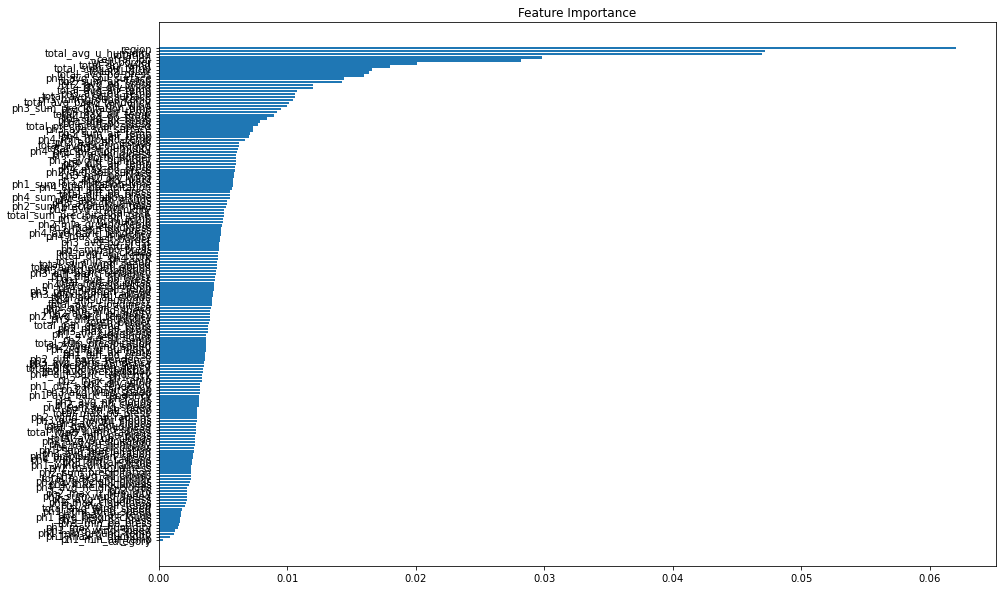

In [54]:
feature_importance = xgb_all_regions.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(15,10))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test_ph.columns)[sorted_idx])
plt.title('Feature Importance')

In [55]:
xgb_all_regions.save_model("RESULTS/MODELS/xgb_all_regions_ph.json")

#### 3.2.2 CatBoost

In [56]:
# Словарь с оптимизированными параметрами модели
params = cat_reg.get_params()
params['iterations'] = 5000

# Инициализация модели для обучения на данных по всем регионам
cat_all_regions = CatBoostRegressor().set_params(**params)

# Обучение модели
cat_all_regions.fit(train_data_ph, eval_set=eval_data_ph, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [57]:
# Прогнозирование модели XGBoost
cat_pred_tot = cat_all_regions.predict(X_test_ph)
# Вычисление RMSE 
cat_rmse_tot = mean_squared_error(y_test_ph, cat_pred_tot, squared=False)
print("CatBoost RMSE : % f" %(cat_rmse_tot))

CatBoost RMSE :  2.163949


In [58]:
importance = cat_all_regions.feature_importances_
features = X_test_ph.columns
feature_importance = pd.DataFrame(zip(features,importance), columns=['features', 'importance'])
feature_importance = feature_importance.sort_values(by=['importance'], ascending=False)
feature_importance.head(30)

,features,importance
151,region,13.287899
153,id_municip,7.673191
160,settl_count,7.353376
159,central_lon,5.984670
154,north_border,5.653917
155,south_border,5.355830
157,west_border,5.207186
156,east_border,5.175137
158,central_lat,4.459459
161,rotation,2.229032


Text(0.5, 1.0, 'Feature Importance')

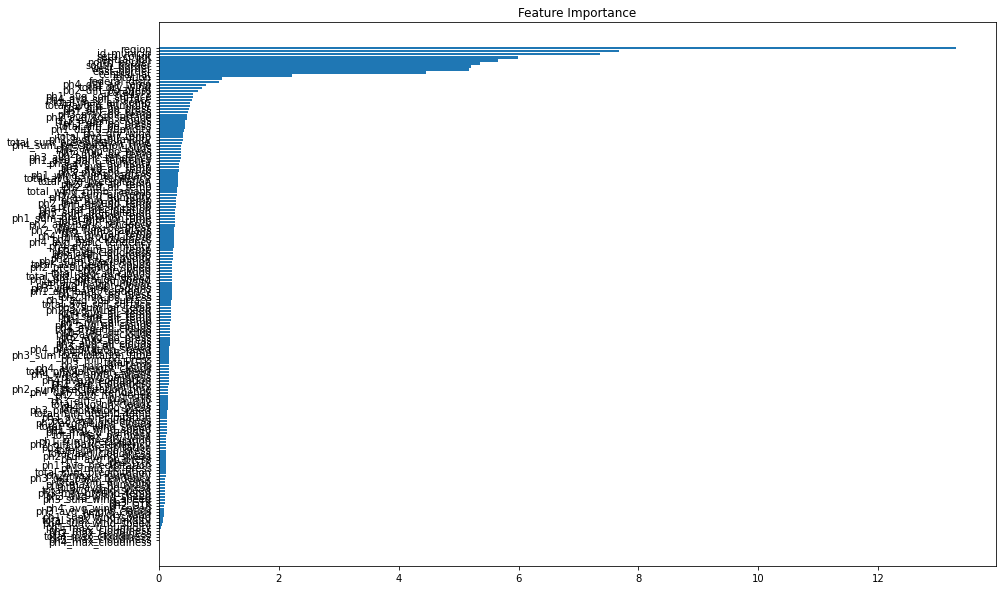

In [59]:
feature_importance = cat_all_regions.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(15,10))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test_ph.columns)[sorted_idx])
plt.title('Feature Importance')

In [60]:
cat_all_regions.save_model("RESULTS/MODELS/cat_all_regions_ph", format="cbm")

### 3.3 Обучение модели на данных по регионам (по муниципалитетам отдельного региона)

#### 3.3.1 XGBoost

In [61]:
# Словарь с оптимизированными параметрами модели
params = xgb_grid.best_params_
params['n_estimators'] = 5000

# Инициализация модели для обучения на данных по всем регионам
xgb_regions = xgb_reg.set_params(**params)

reg_learn = [] # пустой список для сохранения значений RMSE

## Обучение модели по регионам
for r in list(data_ph['region'].unique()):
    reg_iter = [] # пустой список для итераций
    reg_iter.append(le.inverse_transform([r])[0]) # добавление в список наименования региона
    # ОБУЧЕНИЕ И ВАЛИДАЦИЯ
    try:
        # Разбиение данных на переменные и таргет
        train = data_ph.loc[(data_ph['region'] == r)]
        train_label = train['target']
        train = train.drop(columns=['year', 'meteoid', 'target']) # удаление лишних столбцов
        ## Разделение выборки на обучающую и тестовую (90/10) 
        X_train, X_test, y_train, y_test = train_test_split(train, train_label, test_size=0.1, random_state=2)
        # Обучение модели
        xgb_regions.fit(X_train, y_train, verbose=False)
        # прогнозирование на тестовой выборке
        xgb_pred = xgb_regions.predict(X_test)
        # вычисление значения RMSE на тестовой выборке 
        xgb_rmse = mean_squared_error(y_test, xgb_pred, squared=False)
        reg_iter.append(xgb_rmse) # добавление в список значения RMSE
        # сохранение модели для выбранного региона в файл
        xgb_regions.save_model("RESULTS/MODELS/xgb_reg_ph_{}.json".format(le.inverse_transform([r])[0]))
    except:
        # заполнение отсутствующих значений
        xgb_rmse = np.nan
        reg_iter.append(xgb_rmse)
    reg_learn.append(reg_iter) # добавление результатов итерации в список 

C:\Users\uovorop\Anaconda3\lib\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\uovorop\Anaconda3\lib\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\uovorop\Anaconda3\lib\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\uovorop\Anaconda3\lib\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype i

C:\Users\uovorop\Anaconda3\lib\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\uovorop\Anaconda3\lib\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\uovorop\Anaconda3\lib\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\uovorop\Anaconda3\lib\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype i

In [62]:
# Создание и сохранение результатов качества оценки (RMSE) моделей 
region = pd.DataFrame(reg_learn, columns = ['region', 'rmse_test'])
region = region[['region', 'rmse_test']]
region.sort_values(by=['rmse_test'], ascending=False)

,region,rmse_test
11,Нижегородская область,8.790715
20,Республика Ингушетия,6.955401
4,Кабардино-Балкарская Республика,4.427180
37,Кемеровская область,4.354277
7,Красноярский край,3.893238
24,Республика Северная Осетия - Алания,3.659938
6,Краснодарский край,2.937276
34,Чеченская Республика,2.931645
31,Тульская область,2.906768
23,Республика Мордовия,2.845629


In [63]:
# Оценка среднего значения RMSE для всех регионов
test = region.rmse_test.mean()
"rmse_test: {:.3f}".format(test)

'rmse_test: 2.273'

In [64]:
# Сохранение данных с RMSE в файл
file_xgb = region.to_csv('RESULTS/xgb_rmse_reg_phase.csv', sep=';', index=False, encoding='cp1251')

#### 3.3.2 CatBoost

In [71]:
# Словарь с оптимизированными параметрами модели
params = cat_reg.get_params()
params['iterations'] = 5000

# Инициализация модели для обучения на данных по всем регионам
cat_regions = CatBoostRegressor().set_params(**params)

reg_learn = [] # пустой список для сохранения значений RMSE

## Обучение модели по регионам
for r in list(data_ph['region'].unique()):
    reg_iter = [] # пустой список для итераций
    reg_iter.append(le.inverse_transform([r])[0]) # добавление в список наименования региона
    # ОБУЧЕНИЕ И ВАЛИДАЦИЯ
    try:
        # Разбиение данных на переменные и таргет
        train = data_ph.loc[(data_ph['region'] == r)]
        train_label = train['target']
        train = train.drop(columns=['year', 'meteoid', 'target']) # удаление лишних столбцов
        ## Разделение выборки на обучающую и тестовую (90/10) 
        X_train, X_test, y_train, y_test = train_test_split(train, train_label, test_size=0.1, random_state=2)
        # Обучение модели
        cat_regions.fit(X_train, y_train, verbose=False)
        # прогнозирование на тестовой выборке
        cat_pred = cat_regions.predict(X_test)
        # вычисление значения RMSE на тестовой выборке 
        cat_rmse = mean_squared_error(y_test, cat_pred, squared=False)
        reg_iter.append(cat_rmse) # добавление в список значения RMSE
        # сохранение модели для выбранного региона в файл
        cat_regions.save_model('RESULTS/MODELS/cat_reg_ph_{}'.format(le.inverse_transform([r])[0]), format="cbm")
    except:
        # заполнение отсутствующих значений
        cat_rmse = np.nan
        reg_iter.append(cat_rmse)
    reg_learn.append(reg_iter) # добавление результатов итерации в список 

In [72]:
# Созданиехранение результатов качества оценки (RMSE) моделей 
region = pd.DataFrame(reg_learn, columns = ['region', 'rmse_test'])
region = region[['region', 'rmse_test']]
region.sort_values(by=['rmse_test'], ascending=False)

,region,rmse_test
11,Нижегородская область,7.383282
20,Республика Ингушетия,5.563646
37,Кемеровская область,4.329469
4,Кабардино-Балкарская Республика,4.201026
24,Республика Северная Осетия - Алания,3.890534
7,Красноярский край,3.781345
34,Чеченская Республика,3.629663
31,Тульская область,3.398532
23,Республика Мордовия,3.139595
27,Рязанская область,2.984546


In [73]:
test = region.rmse_test.mean()
"rmse_test: {:.3f}".format(test)

'rmse_test: 2.273'

In [74]:
# Сохранение данных в файл
file_cat = region.to_csv('RESULTS/cat_rmse_reg_phase.csv', sep=';', index=False, encoding='cp1251')